# 🎵 MusicDNA: Análisis de Clústeres y Recomendación
Este proyecto utiliza un dataset de **114,000 canciones** de Spotify para identificar patrones musicales y construir un motor de recomendación basado en audio.

**Técnicas utilizadas:** 
- K-Means Clustering (Segmentación)
- PCA (Reducción de dimensionalidad)


### CARGA, LECTURA Y LIMPIEZA DE DATOS
Cargamos los 114,001 registros y preparamos las 20 columnas, centrándonos en las 9 de audio.

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# 1. CARGA (Load)
ddf = pd.read_csv('dataset_spotify.csv', sep=',', on_bad_lines='skip')

C:\Users\Héctor Estéfano\AppData\Local\Temp\ipykernel_27552\1024035117.py:2: DtypeWarning: Columns (0: valence, 1: tempo) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv('dataset_spotify.csv', sep=',', on_bad_lines='skip')


### SELECCIÓN DE FEATURES 

In [38]:
# 2. SELECCIÓN DE FEATURES (Definición del Espacio)
# Solo las variables numéricas que determinan el comportamiento del modelo
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

### ESCALADO

In [39]:
# 3. PREPROCESAMIENTO (Limpieza y Escalado)
# Convertimos a número y eliminamos nulos (paso vital en No Supervisado)
df_model = df.copy()
for col in features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
df_model = df_model.dropna(subset=features)

# Se escala (normaliza) cada columna de features usando StandardScaler, que transforma los datos para que tengan media 0 y desviación estándar 1. 
# Esto es fundamental porque K-Means utiliza distancias y, si no escalamos las variables con valores más grandes dominarán el resultado:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

### MÉTODO DEL CODO 

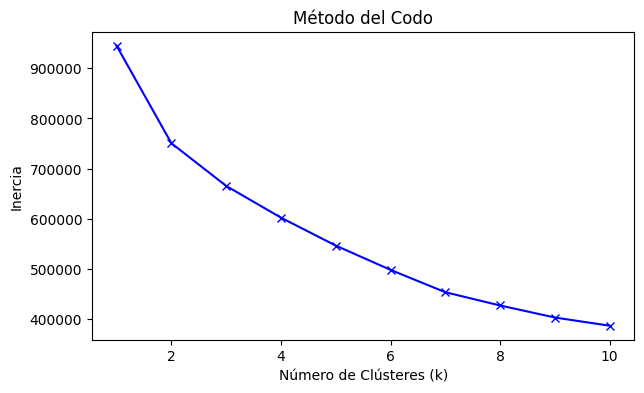

In [40]:
# 4. MÉTODO DEL CODO (Optimización de K)
inercias = []
ks = range(1, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inercias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(ks, inercias, 'bx-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

El gráfico del Método del Codo muestra que la inercia disminuye rápidamente hasta k=3, donde se observa el cambio más marcado en la pendiente. A partir de ese punto, agregar más clústeres apenas 
mejora la inercia. Por lo tanto, el valor óptimo de k es 3, ya que permite una buena segmentación sin sobreajustar el modelo.

### MODELADO FINAL

In [41]:
# 5. MODELADO FINAL (K-Means)
# Usamos k=3 que es el estándar para este dataset
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_model['cluster'] = kmeans.fit_predict(X_scaled)

# 6. INTERPRETACIÓN (Resultados)
print(f"✅ Proceso terminado. Canciones procesadas: {len(df_model)}")
print(df_model[['artists', 'track_name', 'cluster']])

✅ Proceso terminado. Canciones procesadas: 104977
                       artists                   track_name  cluster
0                  Gen Hoshino                       Comedy        2
1                 Ben Woodward             Ghost - Acoustic        1
2       Ingrid Michaelson;ZAYN               To Begin Again        1
3                 Kina Grannis   Can't Help Falling In Love        1
4             Chord Overstreet                      Hold On        1
...                        ...                          ...      ...
113992           Jesus Culture        Your Love Never Fails        0
113993            Chris Tomlin  How Can I Keep From Singing        0
113997           Cesária Evora               Miss Perfumado        1
113998        Michael W. Smith                      Friends        2
113999           Cesária Evora                    Barbincor        2

[104977 rows x 3 columns]


El clúster 0 agrupa canciones con mayor energía y menor acousticness, típicas de música bailable.
El clúster 1 contiene canciones más acústicas y tranquilas.
El clúster 2 se caracteriza por valores intermedios o alguna otra característica relevante.

### PERFILAMIENTO

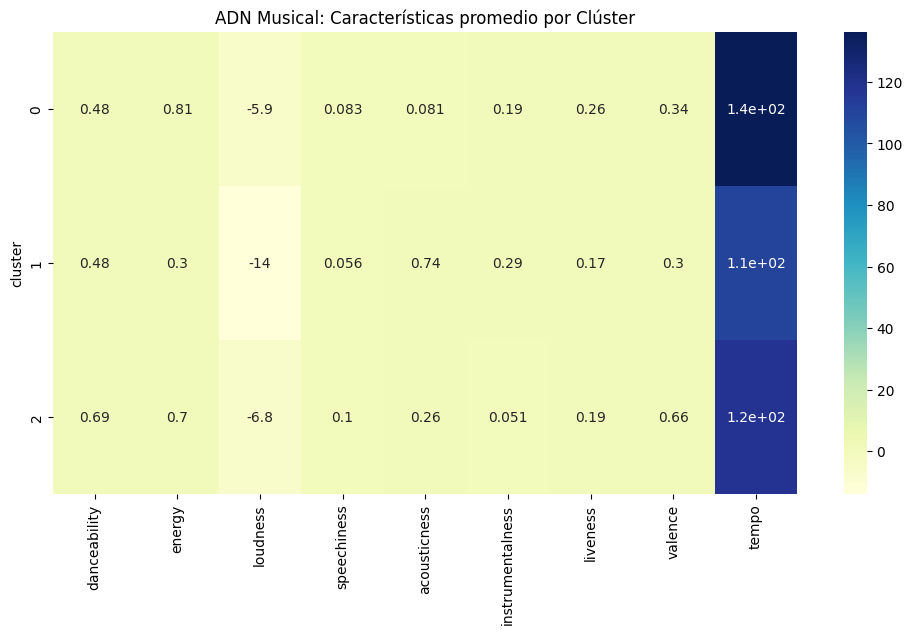

In [42]:
# Analizamos los promedios de cada feature por cluster
perfil_grupos = df_model.groupby('cluster')[features].mean()

# Mostramos un mapa de calor para identificar rápido las diferencias
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(perfil_grupos, annot=True, cmap='YlGnBu')
plt.title('ADN Musical: Características promedio por Clúster')
plt.show()

**Clúster 0 (Energía Máxima / High Energy):**
Es el grupo con mayor Energy (0.81) y mayor Tempo (140).
Tienen el loudness más alto (-5.9).
Interpretación: Aquí están el Rock pesado, Metal, EDM de ritmo rápido y canciones de alta intensidad para entrenar.

**Clúster 1 (Acústico y Relajado / Chill-Acoustic):**
Tiene el valor más alto de Acousticness (0.74).
Su Energy (0.3) y Loudness (-14) son los más bajos de todo el dataset.
Interpretación: Este es el grupo de baladas, música acústica, clásica o de estudio. Es música con mucho "aire" y poco ruido.

**Clúster 2 (Bailable y Comercial / Danceable Pop):**
Es el rey de la Danceability (0.69) y la Valence (0.66) (felicidad/positivismo).
Tiene el menor nivel de Instrumentalness (0.051), lo que significa que casi todas tienen voz.
Interpretación: Aquí vive el Pop, Reggaetón y hits de radio. Son canciones movidas, alegres y diseñadas para bailar.

In [43]:
### VISUALIZACIÓN ESPACIAL

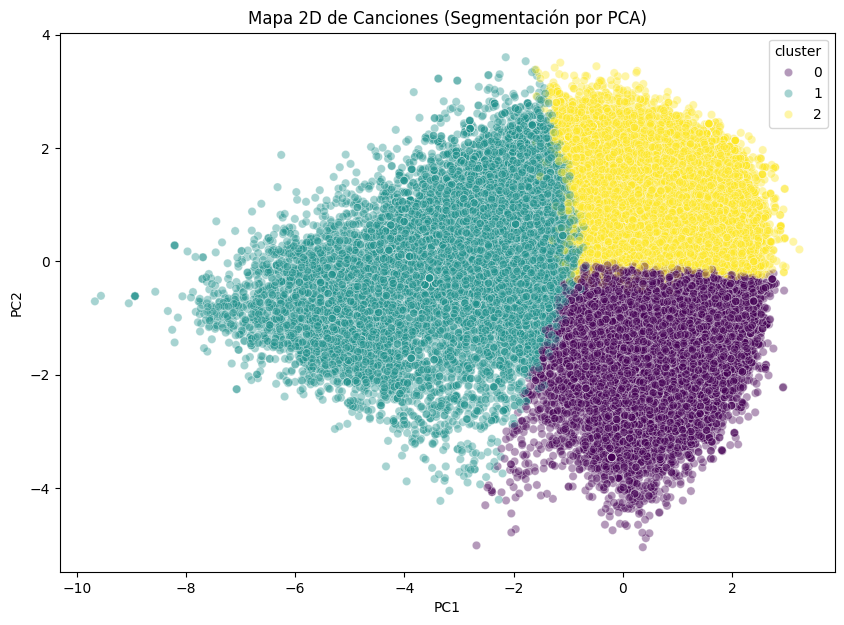

In [44]:
from sklearn.decomposition import PCA

# 1. Reducimos las 9 dimensiones a solo 2 para poder graficar
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

# 2. Creamos un DataFrame para graficar más fácil
df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_model['cluster'].values

# 3. Graficamos la separación de los grupos
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis', alpha=0.4)
plt.title('Mapa 2D de Canciones (Segmentación por PCA)')
plt.show()

**Cluster 1 (Celeste - Izquierda)**: Es el más alejado en el eje PC1 negativo. Son tus canciones con alta Acousticness. El PCA las mandó "al otro lado" porque su ADN es opuesto al de las canciones de fiesta.

**Cluster 0 (Morado - Abajo):** Representa el balance de alta Energy y Loudness. Están agrupadas abajo porque comparten una estructura de ruido similar.

**Cluster 2 (Amarillo - Arriba):** Es el grupo de la Danceability y Valence. Se sitúan arriba porque, aunque tienen energía, su "ritmo" (danceability) las diferencia del rock o metal pesado.

### SISTEMA DE RECOMENDACIÓN POR ADN MUSICAL

Gracias al modelo K-Means que entrené, ahora puedo identificar “gemelos musicales” en mi base de datos. En vez de recomendar simplemente lo más popular, el sistema analiza el sonido de la canción que elijo y detecta a qué grupo musical pertenece según sus características (como ritmo, energía o acústica). Luego, busca entre más de 100,000 canciones y me sugiere otras 5 que comparten ese mismo “ADN musical”, asegurándose de no repetir la canción original. Así, obtengo recomendaciones personalizadas de temas que realmente suenan parecido a lo que me gusta.


In [47]:
def recomendar_canciones(nombre_cancion, top_n=5):
    # 1. Buscar la canción (usamos .iloc[0] por si hay varias con el mismo nombre)
    busqueda = df_model[df_model['track_name'].str.contains(nombre_cancion, case=False, na=False)]
    
    if busqueda.empty:
        return "❌ Canción no encontrada. Revisa si la escribiste bien."
    
    # Datos de la canción encontrada
    cancion_org = busqueda.iloc[0]
    cluster_id = cancion_org['cluster']
    
    # 2. Filtrar: Mismo cluster pero QUE NO SEA la misma canción que buscamos
    recomendaciones = df_model[
        (df_model['cluster'] == cluster_id) & 
        (df_model['track_name'] != cancion_org['track_name'])
    ].sample(top_n)
    
    print(f"Porque escuchaste '{cancion_org['track_name']}' de {cancion_org['artists']}:")
    print(f"Tu perfil es Cluster {cluster_id}. Aquí tienes 5 recomendaciones similares:\n")
    
    return recomendaciones[['artists', 'track_name']].reset_index(drop=True)

# --- PROBAMOS ---
recomendar_canciones('Comedy')

Porque escuchaste 'Comedy' de Gen Hoshino:
Tu perfil es Cluster 2. Aquí tienes 5 recomendaciones similares:



,artists,track_name
0,Andrew Lloyd Webber;Original Evita Cast,Goodnight And Thank You
1,White Zombie,More Human Than Human
2,Blondie,Heart Of Glass
3,Ñejo & Dalmata,Hoy Me Atrevo
4,Wisin & Yandel,Me Estas Tentando
